# Network Anomaly Detection

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Set the file path to the dataset
file_path = r'KDD_dataset.txt'

# Define the column names corresponding to the NSL-KDD dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]


## Reading the Dataset into a DataFrame

In [6]:
df = pd.read_csv(file_path,names=columns)

In [7]:
print(df.head())

   duration protocol_type   service  ... dst_host_srv_rerror_rate   attack  level
0         0           tcp  ftp_data  ...                     0.00   normal     20
1         0           udp     other  ...                     0.00   normal     15
2         0           tcp   private  ...                     0.00  neptune     19
3         0           tcp      http  ...                     0.01   normal     21
4         0           tcp      http  ...                     0.00   normal     21

[5 rows x 43 columns]


## Preprocessing and Splitting the Dataset

In [8]:
# Binary Classification Target
# Map normal traffic to 0 and any type of attack to 1
df['attack_flag'] = df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [10]:
# Multi-class classification target categories
dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
               'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
privilege_attacks = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 
                     'rootkit', 'sqlattack', 'xterm']
access_attacks = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 
                  'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 
                  'snmpguess', 'spy', 'warezclient', 'warezmaster', 
                  'xclock', 'xsnoop']

def map_attack(attack):
    if attack in dos_attacks:
        return 1
    elif attack in probe_attacks:
        return 2
    elif attack in privilege_attacks:
        return 3
    elif attack in access_attacks:
        return 4
    else:
        return 0

# Assign multi-class category to each row
df['attack_map'] = df['attack'].apply(map_attack)

In [11]:
# Encoding categorical variables
features_to_encode = ['protocol_type', 'service']
encoded = pd.get_dummies(df[features_to_encode])

In [12]:
# Numeric features that capture various statistical properties of the traffic
numeric_features = [
    'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 
    'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
    'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate'
]

In [13]:
# Combine encoded categorical variables and numeric features
train_set = encoded.join(df[numeric_features])

# Multi-class target variable
multi_y = df['attack_map']

In [14]:
train_X, test_X, train_y, test_y = train_test_split(train_set, multi_y, test_size=0.2, random_state=1337)

In [15]:
# Further split the training set into separate training and validation sets
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1337)

## Training and Evaluation

In [17]:
# Train RandomForest model for multi-class classification
rf_model_multi = RandomForestClassifier(random_state=1337)
rf_model_multi.fit(multi_train_X, multi_train_y)

RandomForestClassifier(random_state=1337)

Validation Set Evaluation:
Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9950
F1-Score: 0.9949


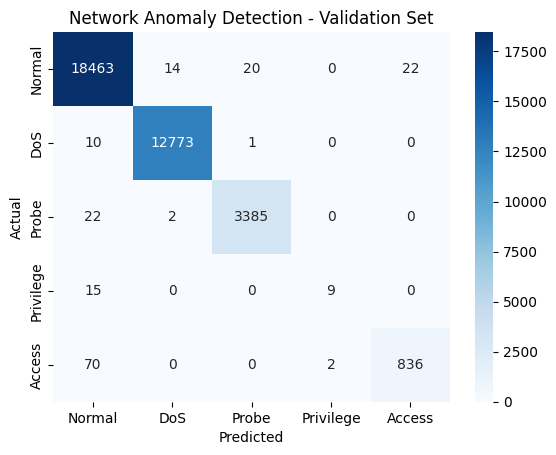

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     18519
         DoS       1.00      1.00      1.00     12784
       Probe       0.99      0.99      0.99      3409
   Privilege       0.82      0.38      0.51        24
      Access       0.97      0.92      0.95       908

    accuracy                           1.00     35644
   macro avg       0.96      0.86      0.89     35644
weighted avg       0.99      1.00      0.99     35644



In [20]:
# Predict and evaluate the model on the validation set
multi_predictions = rf_model_multi.predict(multi_val_X)
accuracy = accuracy_score(multi_val_y, multi_predictions)
precision = precision_score(multi_val_y, multi_predictions, average='weighted')
recall = recall_score(multi_val_y, multi_predictions, average='weighted')
f1 = f1_score(multi_val_y, multi_predictions, average='weighted')
print(f"Validation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix for Validation Set
conf_matrix = confusion_matrix(multi_val_y, multi_predictions)
class_labels = ['Normal', 'DoS', 'Probe', 'Privilege', 'Access']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Network Anomaly Detection - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report for Validation Set
print("Classification Report for Validation Set:")
print(classification_report(multi_val_y, multi_predictions, target_names=class_labels))